<link rel="stylesheet" href="https://fonts.googleapis.com/css?family=Sofia">
<style>
  @import url('https://fonts.googleapis.com/css2?family=Concert+One&display=swap');
  .topic {
    text-align: center;
    font-weight: 900;
    font-size: 50px;
    text-shadow: 3px 3px 3px #ababab;
    font-family: 'Concert One', sans-serif;
  }
  @import url('https://fonts.googleapis.com/css2?family=Lobster&display=swap');
  .info {
    text-align: center;
    font-weight: 800;
    font-size: 40px;
    font-family: 'Lobster', sans-serif;
  }
</style>

<h1 class=topic>Google Analytics Customer Revenue Prediction</h1>
<h2 class=info>Vũ Minh Phát - 21127739</h2>

---

# **<u>Các thư viện cần sử dụng</u>**

In [1]:
# Import Section
import numpy as np
import pandas as pd
from pandas import json_normalize
import json
from zipfile import ZipFile
import tqdm
import datetime as dt
import re
pd.set_option('display.max_columns', None)

# Import matplotlib & seaborn for visualisation
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools

init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
%matplotlib inline

---

# **<u>Đọc dữ liệu thô từ file</u>**

## 1. Xây dựng hàm đọc dữ liệu

In [2]:
# ********** A USEFUL WAY TO READ VERY LARGE DATASETS COMPRESSED IN ZIP FILES **********
#
#   1.  After downloading the data from Kaggle, we will have a zip file
#           which contain our dataset in csv format.
#
#   2.  Because of (very) large size of the dataset, we will not extract the zip file
#           which help us to save our disk space.
#
#   3.  To read file csv in size the zip file, we will use ZipFile library.
#           so we need to define the path to the zip file.
#
#   4.  After that, we can use pandas to read the csv file like normal.
#
# Read more at: https://favtutor.com/blogs/zipfile-python#:~:text=How%20to%20read%20a%20zip,that%20we%20want%20to%20read.
# **************************************************************************************
ZIP_FILE_PATH = '../data/raw/ga-customer-revenue-prediction.zip'

In [3]:
def read_data_inside_zip_file(filename: str, zip_file_path: str = ZIP_FILE_PATH) -> pd.DataFrame:
    """Read the csv file inside the zip file
    
    Notes:
        zip_file_path is the path to the zip file containing the csv file

    Returns:
        pd.DataFrame: dataframe of 'filename' inside the zip file
    """
    with ZipFile(zip_file_path) as zf:      # Open the zip file with mode 'r'
        with zf.open(filename) as file:     # Open 'filename' inside the zip file
            df = pd.read_csv(file)          # Read data from 'filename'
                                            #   => Q: Why NOT set low_memory=False to solve DtypeWarning?
                                            #      A: Read at: https://stackoverflow.com/questions/24251219/pandas-read-csv-low-memory-and-dtype-options

    return df

## 2. Đọc dữ liệu

In [4]:
# Read the data
raw_df = read_data_inside_zip_file('train.csv')

/tmp/ipykernel_30755/1298650587.py:12: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



> Khi sử dụng `read_csv()` từ `Pandas`, thông báo `DtypeWarning` xuất hiện 
> đồng nghĩa với việc file dữ liệu có (ít nhất) 1 cột bao gồm nhiều kiểu dữ liệu (dtype).

Cột gây ra thông báo là:

In [5]:
# Columns (3) give DtypeWarning -> corresponding index is 3
print(f"=> Column give DtypeWarning: {raw_df.columns[3]}")

=> Column give DtypeWarning: fullVisitorId


> Trong trường hợp này, cột `fullVisitorId` là nguyên nhân của thông báo trên. Ta sẽ quan sát toàn bộ dữ liệu đã đọc và tìm cách xử lý.

Ta xem một vài mẫu có trong tập dữ liệu:

In [6]:
raw_df.head(5)

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600


## 📌 Dữ liệu thô có bao nhiêu dòng và bao nhiêu cột?

Mô tả tổng quát dữ liệu

In [7]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   channelGrouping       903653 non-null  object
 1   date                  903653 non-null  int64 
 2   device                903653 non-null  object
 3   fullVisitorId         903653 non-null  object
 4   geoNetwork            903653 non-null  object
 5   sessionId             903653 non-null  object
 6   socialEngagementType  903653 non-null  object
 7   totals                903653 non-null  object
 8   trafficSource         903653 non-null  object
 9   visitId               903653 non-null  int64 
 10  visitNumber           903653 non-null  int64 
 11  visitStartTime        903653 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 82.7+ MB


Ta tìm số lượng dòng và cột của tập dữ liệu để trả lời câu hỏi

In [8]:
# Calculate the number of rows and columns
nrows, ncols = raw_df.shape

# Answer the question
print(f">> Number of rows: {nrows}")
print(f">> Number of columns: {ncols}")

>> Number of rows: 903653
>> Number of columns: 12


> 💭 Dữ liệu thô có `903653 dòng` và `12 cột`.

## 📌 Mỗi dòng có ý nghĩa là gì? Dữ liệu có gặp phải vấn đề các dòng có ý nghĩa khác nhau hay không?

> 🖋️ <u>*Trả lời:*</u>
>   * Mỗi dòng sẽ lưu các thông tin trong một phiên truy cập tới GStore từ người dùng. Cụ thể hơn, mỗi dòng cho ta biết *12* thông tin ứng với *12* trường dữ liệu (còn ý nghĩa của mỗi trường dữ liệu thì ta sẽ đề cập sau).
>
>   * Nhìn sơ qua toàn bộ bảng dữ liệu trong file `train.csv` được cung cấp bởi [Kaggle](https://www.kaggle.com/competitions/ga-customer-revenue-prediction/data?select=train.csv) thì có vẻ không thấy có dòng nào bất thường. Các dòng đều có cấu trúc giống nhau, thể hiện thông qua <u>thứ tự</u> và <u>kiểu dữ liệu</u> mà nó lưu trữ. (Và điều này được thể hiện rất rõ khi quan sát hình bên dưới, ta thấy thứ tự lưu trữ của mỗi dòng đều giống nhau: đầu tiên là đoạn văn bản, kế tiếp là 8 chữ số, sau đó đến 1 dữ liệu hỗn hợp khá giống `dictionay`, v.v.)
>
> ![Demo `train.csv`](./figures/demo_train_csv.png "Demo `train.csv`")

## 📌 Dữ liệu có các dòng bị lặp không?

Ta tính số lượng các dòng bị trùng `index`. Trong số các dòng có `index` giống nhau, thì dòng đầu tiên không được tính là lặp lại.

In [9]:
# Calculate the number of duplicated rows
index = raw_df.index
detectDupSeries = index.duplicated(keep='first')
num_duplicated_rows = detectDupSeries.sum()

# Show the result
if num_duplicated_rows == 0: 
    print(f">> Your raw data have no duplicated line!")
else:
    ext = "lines" if num_duplicated_rows > 1 else "line"
    print(f">> Your raw data have {num_duplicated_rows} duplicated " + ext + ". Please de-deduplicate your raw data!")

>> Your raw data have no duplicated line!


> 💭 <u>*Nhận xét:*</u> Dữ liệu của chúng ta không có dòng nào bị lặp lại nên ta không cần xử lý gì thêm. Tiếp theo, ta sẽ chuyển sang tìm hiểu về các cột.

## 📌 Mỗi cột có ý nghĩa là gì?

<class style="font-size: 18px;">

> Ý nghĩa của từng cột:
> * **`channelGrouping`** - Cho biết kênh mà người dùng đã truy cập đến GStore (Google swag online store).
> 
> * **`date`** - Cho biết Ngày mà người dùng truy cập vào GStore.
> 
> * **`device`** - Chứa thông số kỹ thuật của thiết bị được sử dụng để truy cập vào GStore và thể hiện dưới dạng <u>giá trị tổng hợp</u>. (Ví dụ: tên và phiên bản của `browser`; hệ điều hành của thiết bị; v.v.)
> 
> * **`fullVisitorId`** - Cho biết mã định danh riêng cho mỗi người dùng của Google Merchandise Store.
> 
> * **`geoNetwork`** - Cho biết thông tin vị trí địa lý của người dùng được thể hiện dưới dạng <u>giá trị tổng hợp</u>. (Chẳng hạn như tên của: `city`, `continent`, `country`, v.v.)
> 
> * **`sessionId`** - Được tạo thành từ **`fullVisitorId`** và **`visitId`**.
> 
> * **`socialEngagementType`** - Chứa một trong hai giá trị: "Socially Engaged" hoặc "Not Socially Engaged".
> 
> * **`totals`** - Chứa các <u>giá trị tổng hợp</u> trong suốt phiên ghé thăm của mỗi người dùng. (Ví dụ như: số lượng trang đã xem; tổng thời gian của phiên được tính bằng giây; v.v.)
> 
> * **`trafficSource`** - Cho biết thông tin về Traffic Source mà phiên bắt đầu, được thể hiện dưới dạng <u>giá trị tổng hợp</u>. (Chẳng hạn như: `keyword` hay chuỗi đường dẫn đưa người dùng đến trang web, v.v.)
> 
> * **`visitId`** - Cho biết mã định danh của mỗi phiên (giá trị này có thể giống nhau ở các người dùng khác nhau). Đây là một phần của giá trị thường được lưu trữ dưới dạng cookie `_utmb`.
> 
> * **`visitNumber`** - Lưu trữ số lượng phiên truy cập của từng người dùng. Nếu đây là phiên đầu tiên thì giá trị này được đặt thành *1*. Giá trị này tăng dần sau mỗi lần người dùng truy cập đến trang web.
> 
> * **`visitStartTime`** - Timestamp (được biểu thị bằng thời gian POSIX) cho biết thời gian người dùng bắt đầu truy cập đến trang web.
>
> <i>(Những thông tin mô tả bên trên đã được tham khảo từ 2 nguồn tài liệu là: [Kaggle - Dataset Description](https://www.kaggle.com/competitions/ga-customer-revenue-prediction/data) và [[UA] BigQuery Export schema](https://support.google.com/analytics/answer/3437719?hl=en-GBanswer=1686200))</i>

</class>

## 📌 Cách thức lưu trữ dữ liệu trong các cột như hiện tại có phù hợp để có thể xử lý tiếp hay không?

- Dữ liệu ban đầu có 12 cột. Sau khi tìm hiểu về ý nghĩa của chúng thì ta phát hiện có 4 thuộc tính là: `device`, `geoNetwork`, `totals` và `trafficSource` đang lưu trữ dữ liệu dưới dạng `JSON` (dữ liệu hỗn hợp) rất khó để phân tích.

- Vậy ta đề ra giải pháp là cần *"làm phẳng"* dữ liệu, tức là: biến đổi dữ liệu thô từ trong file `train.csv` thành một bảng dữ liệu, sao cho mỗi cột chỉ thể hiện một thông tin duy nhất (và không thể chia nhỏ hơn nữa).

## 🚧 Tiền xử lý: Đọc dữ liệu và làm phẳng

Ta có thể sử dụng đoạn code của [DATAISTA0 (JULIÁN PELLER)](https://www.kaggle.com/code/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook) để thực hiện việc này.

In [3]:
# From: https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields
def read_data_and_flatten(filename: str, nrows: int = None, 
                          zip_file_path: str = ZIP_FILE_PATH) -> pd.DataFrame:
    """Read the csv file inside the zip file and flatten json columns"""
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    with ZipFile(zip_file_path) as zf:
        with zf.open(filename) as file:
            df = pd.read_csv(file,
                             # Create JSON object for every json column
                             converters={col: json.loads for col in JSON_COLUMNS},
                             # Important!! Considering 'fullvisitor id as string'
                             dtype={'fullVisitorId': 'str'},
                             nrows=nrows)
            
    with tqdm.tqdm(total=len(JSON_COLUMNS)) as pbar:
        pbar.set_description(f"Flattening process")
        for column in JSON_COLUMNS:
            # json_normalize will return a flatten dataframe of json columns
            column_as_df = json_normalize(df[column])
            # Get column names
            column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
            # Drop JSON columns and merge data frame with parsed columns
            df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
            
            pbar.update(1)
    
    print(f">> Loaded '{filename}' with shape: {df.shape}")
    return df

In [4]:
# Read the data and flatten json columns
flattened_df = read_data_and_flatten('train.csv')

Flattening process: 100%|██████████| 4/4 [00:33<00:00,  8.49s/it]


>> Loaded 'train.csv' with shape: (903653, 55)


> Ta thấy tham số `dtype={'fullVisitorId': 'str'}` trong hàm `read_csv()` giúp
> thông báo `DtypeWarning` không còn xuất hiện.

Bây giờ ta sẽ quan sát dữ liệu sau khi biến đổi:

In [5]:
flattened_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

## 📌 Dữ liệu sau khi làm phẳng có bao nhiêu dòng và bao nhiêu cột?

Danh sách các cột dữ liệu:

In [6]:
flattened_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    903653 non-null  object
 1   date                                               903653 non-null  int64 
 2   fullVisitorId                                      903653 non-null  object
 3   sessionId                                          903653 non-null  object
 4   socialEngagementType                               903653 non-null  object
 5   visitId                                            903653 non-null  int64 
 6   visitNumber                                        903653 non-null  int64 
 7   visitStartTime                                     903653 non-null  int64 
 8   device.browser                                     903653 non-null  object
 9   devi

Số dòng và số cột:

In [7]:
# Calculate the number of rows and columns
nrows, ncols = flattened_df.shape

# Answer the question
print(f">> Number of rows: {nrows}")
print(f">> Number of columns: {ncols}")

>> Number of rows: 903653
>> Number of columns: 55


> 💭 <u>*Quan sát:*</u>
>
> * Sau quá trình làm phẳng, số dòng của dữ liệu vẫn không đổi là `903653` đúng như ta mong đợi. Tuy nhiên, số cột đã được nâng lên con số `55`. 
>
> * Ta thấy `12` cột ban đầu đã được xử lý bằng cách:
>   * 4 cột: `device`, `geoNetwork`, `totals` và `trafficSource` đã được tách thành các cột nhỏ hơn và có thể dễ dàng nhận biết thông qua định dạng `<JSON_Column_Names>.<Keys_In_JSON_Object>[.<Keys_In_Sub_JSON_Object>]` (tức là dùng ký tự `.` để phân tách). Khi này sự xuất hiện của 4 cột ban đầu là không cần thiết nên ta đã loại bỏ ngay từ khâu xử lý bên trên.
>
>   * Các cột còn lại thì không cần thay đổi nên chúng được giữ nguyên.
>
> * Nếu quan sát kỹ hơn vào bảng mô tả bên trên thì ta phát hiện có rất nhiều cột bị thiếu dữ liệu. Đồng thời `55` là con số tương đối lớn, nếu được thì ta có thể giảm bớt độ rộng của dữ liệu để tiết kiệm chi phí lưu trữ và thời gian ở các bước phân tích tiếp theo.

## 🚧 Tiền xử lý: Loại bỏ các cột không có nhiều ý nghĩa trong quá trình phân tích

##### ⁂ Các cột mang tính chất nhận diện (`*ID`)

In [8]:
id_cols = ['fullVisitorId', 'sessionId', 'visitId', 'visitStartTime']
flattened_df.loc[:4, id_cols]

,fullVisitorId,sessionId,visitId,visitStartTime
0,1131660440785968503,1131660440785968503_1472830385,1472830385,1472830385
1,377306020877927890,377306020877927890_1472880147,1472880147,1472880147
2,3895546263509774583,3895546263509774583_1472865386,1472865386,1472865386
3,4763447161404445595,4763447161404445595_1472881213,1472881213,1472881213
4,27294437909732085,27294437909732085_1472822600,1472822600,1472822600


> *Ghi chú:*
>   * `sessionId` = `fullVisitorId` + `visitId`
>   * `visitId` ~ `visitStartTime` (thực ra là bé hơn hoặc bằng)

Mức độ tương đồng giữa 2 thuộc tính `visitId` và `visitStartTime`

In [9]:
# Calculate similarity between 'visitId' and 'visitStartTime'
np.sum(flattened_df['visitId'] == flattened_df['visitStartTime']) / flattened_df.shape[0] * 100

99.47889289362178

> 💡 <u>Nhận xét</u>: Về mặt lý thuyết, các cột trong `id_cols` thường mang các giá trị phân loại (`categorical data`) có tính chất tính định danh, giúp xác định mỗi người dùng và các phiên truy cập khác nhau. Các dữ liệu này sẽ không giúp ích quá nhiều khi phân tích dữ liệu nên ta có thể xóa chúng.

🔨 Bỏ các cột `id_cols` khỏi tập dữ liệu

In [11]:
flattened_df.drop(id_cols, axis=1, inplace=True)

##### ⁂ Các cột thiếu dữ liệu HOÀN TOÀN

In [12]:
cols_with_completely_missing = [col 
                                for col in flattened_df.columns 
                                if flattened_df[col].isnull().all()]
cols_with_completely_missing

[]

> Suy ra, không có cột nào hoàn toàn thiếu dữ liệu.
> Nghĩa là, không có cột nào chỉ chứa giá trị `NaN`.

##### ⁂ Các cột chỉ có duy nhất 1 giá trị

In [13]:
cols_with_unique_value = [col 
                          for col in flattened_df.columns 
                          if flattened_df[col].nunique(dropna=True) == 1]
cols_with_unique_value

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.bounces',
 'totals.newVisits',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.isTrueDirect',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.campaignCode']

> * Trên lý thuyết, các cột chỉ có DUY NHẤT 1 giá trị (khác `NaN`) thì cũng không có ý nghĩa gì khi dùng để dự đoán kết quả.
>
> * Do đó, ta có thể xóa các cột này để thu hẹp phạm vi dữ liệu.

🔨 Xóa các cột chỉ có 1 giá trị duy nhất

In [14]:
# Drop columns with unique value
flattened_df.drop(cols_with_unique_value, axis='columns', inplace=True)

Khi này dữ liệu còn lại:

In [15]:
flattened_df.head()

,channelGrouping,date,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adContent
0,Organic Search,20160902,1,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,ttnet.com.tr,1,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,1,Firefox,Macintosh,False,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,1,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,1,Chrome,Windows,False,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,unknown.unknown,1,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,1,UC Browser,Linux,False,desktop,Asia,Southeast Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1,1,NaN,(not set),google,organic,google + online,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20160902,2,Chrome,Android,True,mobile,Europe,Northern Europe,United Kingdom,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,1,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
flattened_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 27 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------                                        --------------   ----- 
 0   channelGrouping                               903653 non-null  object
 1   date                                          903653 non-null  int64 
 2   visitNumber                                   903653 non-null  int64 
 3   device.browser                                903653 non-null  object
 4   device.operatingSystem                        903653 non-null  object
 5   device.isMobile                               903653 non-null  bool  
 6   device.deviceCategory                         903653 non-null  object
 7   geoNetwork.continent                          903653 non-null  object
 8   geoNetwork.subContinent                       903653 non-null  object
 9   geoNetwork.country                            903653 non-nu

> Khi này, số dòng không đổi nhưng dữ liệu chỉ còn `27 cột` và có 1 vài `cell` bị thiếu dữ liệu.

##### 💾 Ta lưu lại dữ liệu này để backup

In [17]:
flattened_df.to_csv('../data/processed/train_reduced.csv', index=False, na_rep='None')

In [18]:
# Đọc dữ liệu đã được làm phẳng và giảm số lượng cột (nếu cần)
reduced_df = pd.read_csv('../data/processed/train_reduced.csv')

___

##### Ta phân tích tình trạng thiếu dữ liệu của các cột còn lại

In [4]:
# From: https://stackoverflow.com/questions/51070985/find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset
def _create_missing_value_df(df: pd.DataFrame) -> pd.DataFrame:
    """Create a dataframe containing information about missing values in df"""
    percent_missing = df.isnull().sum() * 100 / df.shape[0]
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})
    missing_value_df.reset_index(drop=True, inplace=True)
    missing_value_df.sort_values(by='percent_missing', ascending=False, inplace=True)
    return missing_value_df

# Check how much percentage of missing data in each colummn:
missing_value_df = _create_missing_value_df(train_df)
missing_value_df.head(12)

,column_name,percent_missing
26,trafficSource.adContent,98.788694
16,totals.transactionRevenue,98.725728
22,trafficSource.adwordsClickInfo.page,97.625195
23,trafficSource.adwordsClickInfo.slot,97.625195
25,trafficSource.adwordsClickInfo.adNetworkType,97.625195
24,trafficSource.adwordsClickInfo.gclId,97.614018
21,trafficSource.referralPath,63.377425
20,trafficSource.keyword,55.655102
15,totals.pageviews,0.011066
1,date,0.000000


Ta có thể biễu diễn dưới dạng đồ thị để dễ quan sát hơn

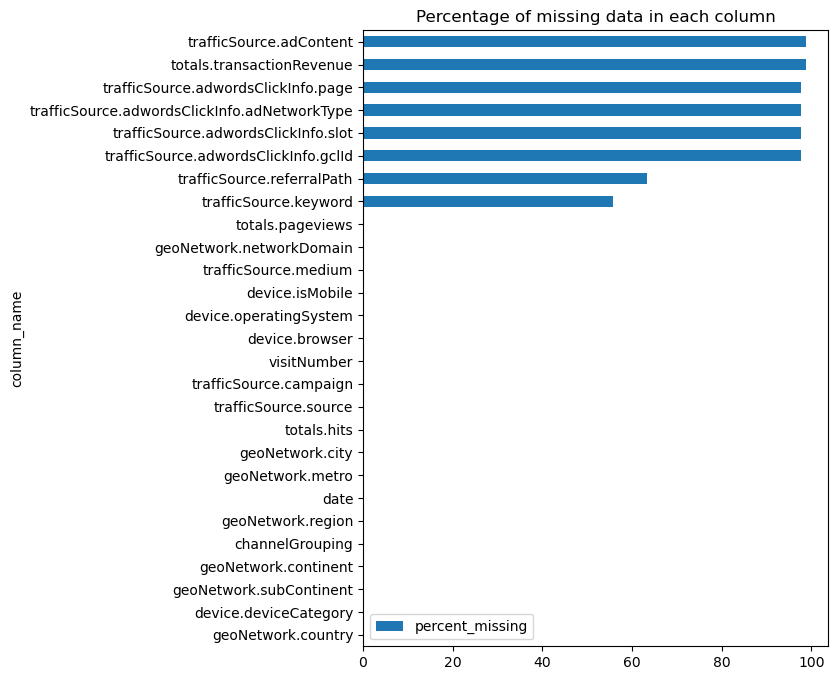

In [5]:
missing_value_df.sort_values(by='percent_missing', ascending=True)\
                    .plot.barh(x='column_name',
                               y='percent_missing',
                               figsize=(6, 8),
                               title='Percentage of missing data in each column');

## 4.5. Phân tích cụ thể từng cột bị thiếu giá trị

#### 🎯 `totals.transactionRevenue`

🔭 Ta xem các giá trị có trong cột này

In [6]:
train_df['totals.transactionRevenue'].describe()

count    1.151500e+04
mean     1.337448e+08
std      4.482852e+08
min      1.000000e+04
25%      2.493000e+07
50%      4.945000e+07
75%      1.076550e+08
max      2.312950e+10
Name: totals.transactionRevenue, dtype: float64

In [7]:
train_df['totals.transactionRevenue'].unique()

array([       nan, 3.7860e+07, 3.0667e+08, ..., 3.3526e+08, 3.0750e+07,
       6.9390e+07])

> Cột này thể hiện tổng giá trị giao dịch trong phiên nên ta chỉ cần 
> thay các giá trị `NaN` bằng `0`.

🔨 Điền giá trị `0` vào các ô bị trống

In [8]:
train_df['totals.transactionRevenue'].fillna(0, inplace=True)

#### ✂️ Với các cột bị thiếu nhiều dữ liệu

Các thuộc tính bị thiếu quá nhiều dữ liệu (trừ giá trị mục tiêu) thường không quá hữu ích khi dùng trong phân tích. Với từng tập dữ liệu khác nhau thì ngưỡng đặt ra cũng khác nhau. Thông thường, nếu 1 cột có hơn `75%` dữ liệu bị thiếu thì đây cột này được xem là thiếu dữ liệu trầm trọng ta sẽ ưu tiên loại bỏ nó khỏi tập dữ liệu.

In [9]:
def drop_missing_features(df: pd.DataFrame, missing_lst: dict, threshold: float = 75.0) -> pd.DataFrame:
    """Drop missing features from Pandas dataframe base on given threshold.

    Args:
        df (pd.DataFrame): Input dataframe for processing.
        missing_lst (dict, optional): Dict missing value rate which calculated from previous stage. Defaults to dict(num_col_info_df.iloc[0]).
        threshold (float, optional): User threshold for dropping. Defaults to 75.0.

    Returns:
        pd.DataFrame: Updated dataframe
    """
    # YOUR CODE HERE
    # raise NotImplementedError()
    if (df is None) or (missing_lst is None) or (threshold is None):
        print(f"[LOG] Invalid.")
        raise ValueError
    
    # Create a copy of the dataframe to avoid changing the original
    df_cp = df.copy()
    
    # List to maintain the columns to drop
    cols_to_trim = []
    
    for key, value in missing_lst.items():
        if float(value) > threshold:
            cols_to_trim.append(key)
            
    if len(cols_to_trim) > 0:
        # drop the columns identified using the dataframe drop() method
        df_cp = df_cp.drop(columns=cols_to_trim)
        print("[LOG] Dropped column(s): " + "\n + ".join([""]+cols_to_trim))
    else:
        print("[LOG] Have no column(s) to trim.")
        
    return df_cp

In [10]:
train_df = drop_missing_features(
    train_df, 
    {col_name: percent_missing
     for col_name, percent_missing in zip(missing_value_df['column_name'],
                                          missing_value_df['percent_missing'])}
)

[LOG] Dropped column(s): 
 + trafficSource.adContent
 + totals.transactionRevenue
 + trafficSource.adwordsClickInfo.page
 + trafficSource.adwordsClickInfo.slot
 + trafficSource.adwordsClickInfo.adNetworkType
 + trafficSource.adwordsClickInfo.gclId


In [11]:
train_df.shape

(903653, 21)

> Sau khi loại bỏ các cột bị thiếu nhiều giá trị, dữ liệu của chúng ta chỉ còn `21` cột.

❓ Tình trạng thiếu dữ liệu của các cột còn lại

In [12]:
missing_value_df = _create_missing_value_df(train_df)
missing_value_df.head(5)

,column_name,percent_missing
20,trafficSource.referralPath,63.377425
19,trafficSource.keyword,55.655102
15,totals.pageviews,0.011066
1,date,0.000000
0,channelGrouping,0.000000


#### 🔍 Ta quan sát các cột còn bị thiếu giá trị

##### 🤔 `trafficSource.referralPath`

Ta quan sát một vài giá trị trong cột này

In [13]:
train_df['trafficSource.referralPath'].value_counts(dropna=False)

trafficSource.referralPath
NaN                                                                                                                                                                                                                 572712
/                                                                                                                                                                                                                    75523
/yt/about/                                                                                                                                                                                                           71036
/analytics/web/                                                                                                                                                                                                      14620
/yt/about/tr/                                                                                    

> * [Referral Path](https://neilpatel.com/blog/referral-paths-in-google-analytics/) đề cập
> đến đường dẫn hoặc chuỗi các trang web mà người dùng đã truy cập để đến trang web hiện tại.
>
> * Trong Google Analytics, `Referral Path` cho phép chúng ta xem các trang web khác đã 
> giới thiệu người dùng đến trang web của mình.
>
> * Thuộc tính này có hơn `60%` dữ liệu bị thiếu và các giá trị có trong cột cũng tương đối và khó phân tích nên ta có thể bỏ cột này khỏi tập dữ liệu

🔨 Loại bỏ cột `trafficSource.referralPath` khỏi tập dữ liệu

In [14]:
if 'trafficSource.referralPath' in train_df.columns:
    train_df.drop('trafficSource.referralPath', axis=1, inplace=True)

##### 🤔 `trafficSource.keyword`

Ta xem một vài giá trị có trong cột này

In [15]:
keyword_val_counts = train_df['trafficSource.keyword'].value_counts(dropna=False)
keyword_val_counts[:10]

trafficSource.keyword
NaN                                502929
(not provided)                     366363
6qEhsCssdK0z36ri                    11503
(Remarketing/Content targeting)      2298
1hZbAqLCbjwfgOH7                     2264
google merchandise store             2209
Google Merchandise                   1648
google store                         1277
youtube                               568
(User vertical targeting)             489
Name: count, dtype: int64

In [16]:
# Propotion of meaningless value in 'trafficSource.keyword'
meaningless_keyword_prop = keyword_val_counts[:2].values.sum() \
                            / keyword_val_counts.values.sum() * 100
print(f"Proportion of meaningless value in `trafficSource.keyword`: {meaningless_keyword_prop:.2f}%")

Proportion of meaningless value in `trafficSource.keyword`: 96.20%


> * Về mặt lý thuyết thì thuộc tính này chỉ có khoảng *55%* dữ liệu bị thiếu. Nhưng trên thực tế có đến khoảng *96%* dữ liệu trong cột này là chưa thể sử dụng được.
> * Do đó, ta sẽ loại bỏ cột này khỏi tập dữ liệu.

❗ Loại bỏ cột `trafficSource.keyword` khỏi tập dữ liệu

In [17]:
# Drop 'trafficSource.keyword' column
if 'trafficSource.keyword' in train_df.columns:
    train_df.drop('trafficSource.keyword', axis=1, inplace=True)

##### ⌘ `totals.pageviews`

Ta xem mô tả của cột `totals.pageviews`

In [18]:
train_df['totals.pageviews'].describe()

count    903553.000000
mean          3.849764
std           7.025274
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max         469.000000
Name: totals.pageviews, dtype: float64

> <u>*Nhận xét:*</u> 
>   * Vì cột này bị thiếu dữ liệu nên ta có thể thay thế giá trị `NaN` thành giá trị `median` của cột. 
>
>   * Cũng chính giá trị `NaN` đã làm cho cột này có kiểu dữ liệu `float64`. Do đó ta cũng cần chuyển đổi kiểu dữ liệu của cột này thành `int`.

❗ Thay giá trị bị thiếu bằng `median` của cột `totals.pageviews` và chuyển đổi kiểu dữ liệu của cột này thành `int`

In [19]:
# Fill `nan` with median value
train_df['totals.pageviews'].fillna(train_df['totals.pageviews'].median(), inplace=True)

# Change datatype of column to `int`
train_df['totals.pageviews'] = train_df['totals.pageviews'].astype(np.int_)

# Display result
print(f"Number of missing values: {train_df['totals.pageviews'].isnull().sum()}")
print(f"totals.pageviews's dtype: {train_df['totals.pageviews'].dtype}")

Number of missing values: 0
totals.pageviews's dtype: int64


#### 🔍 Ta quan sát các cột không thiếu giá trị

##### ⌘ `date` 

✍ Ta quan sát một vài giá trị và kiểu dữ liệu của thuộc tính này

In [20]:
train_df["date"][100000:100005]

100000    20161030
100001    20161030
100002    20161030
100003    20161030
100004    20161030
Name: date, dtype: int64

> 💡 <u>*Quan sát*</u>: 
> * Cột `date` đang có kiểu dữ liệu là `int` và mỗi giá trị trong cột có định dạng "YYYY_MM_DD". Ta sẽ chuyển các giá trị trong cột này sang kiểu `datetime`.

🔨 Chuyển các giá trị trong cột `date` sang kiểu `datetime`

In [21]:
# Convert date to datetime type
train_df['date'] = pd.to_datetime(train_df['date'], format='%Y%m%d')

# Check the result
train_df['date'][100000:100005]

100000   2016-10-30
100001   2016-10-30
100002   2016-10-30
100003   2016-10-30
100004   2016-10-30
Name: date, dtype: datetime64[ns]

✨ Vì cột `date` chỉ mang giá trị tổng quát nên ta có thể trích xuất ra các thông tin hữu ích hơn từ dữ liệu này. Sau đó, ta có thể bỏ cột `date` khỏi tập dữ liệu để tiết kiệm không gian lưu trữ.

In [22]:
if 'date' in train_df.columns:
    # Extract time features from `date` column
    train_df['date.day']        = train_df['date'].dt.day
    train_df['date.year']       = train_df['date'].dt.year
    train_df['date.month']      = train_df['date'].dt.month
    train_df['date.weekDay']    = train_df['date'].dt.weekday
    train_df['date.weekOfYear'] = train_df['date'].dt.isocalendar().week

    # Drop `date` column
    train_df.drop('date', axis=1, inplace=True)

##### `visitNumber` ✅

Ta quan sát kiểu dữ liệu và phân bố của cột này

In [23]:
print(f">> `visitNumber` column datatype: {train_df['visitNumber'].dtype}")
train_df['visitNumber'].describe()

>> `visitNumber` column datatype: int64


count    903653.000000
mean          2.264897
std           9.283735
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         395.000000
Name: visitNumber, dtype: float64

> Kiểu dữ liệu của cột này là `int64` cũng là kiểu dữ liệu mà ta mong đợi nên ta không cần xử lý thêm.

##### `channelGrouping` ✅

✍ Phân loại `channelGrouping`:

In [24]:
train_df["channelGrouping"].value_counts(dropna=False)

channelGrouping
Organic Search    381561
Social            226117
Direct            143026
Referral          104838
Paid Search        25326
Affiliates         16403
Display             6262
(Other)              120
Name: count, dtype: int64

> 💡 <u>*Quan sát*</u>: Thuộc tính này không bị thiếu dữ liệu và tất cả giá trị đều không cần chỉnh sửa.

##### ⌘ `device.operatingSystem`

❓ Có bao nhiêu loại *hệ điều hành* được người dùng sử dụng và số lượng của từng loại?

In [25]:
train_df["device.operatingSystem"].value_counts(dropna=False)

device.operatingSystem
Windows          350072
Macintosh        253938
Android          123892
iOS              107665
Linux             35034
Chrome OS         26337
(not set)          4695
Windows Phone      1216
Samsung             280
BlackBerry          218
Nintendo Wii        100
Firefox OS           89
Xbox                 66
Nintendo WiiU        35
FreeBSD               9
Nokia                 2
OpenBSD               2
NTT DoCoMo            1
Nintendo 3DS          1
SunOS                 1
Name: count, dtype: int64

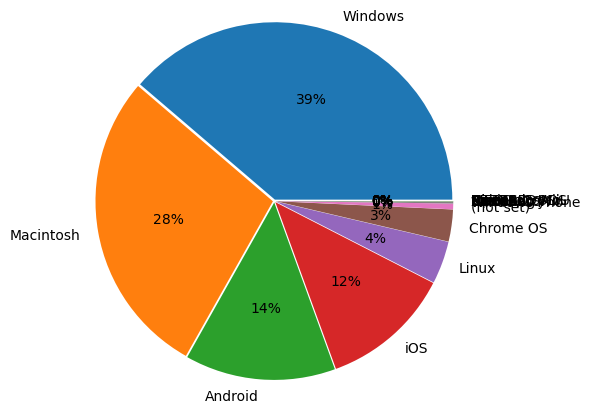

In [26]:
device_os = train_df["device.operatingSystem"].value_counts()
plt.pie(device_os, radius=1.2, labels=device_os.index, 
        autopct='%1.0f%%', explode=[0.01]*device_os.size);

> 💡 <u>*Quan sát*</u>: 
> * Ta có thể kể tên một vài hệ điều hành được sử dụng phổ biến là: Windows, Macintosh, Android, v.v. 
> * Đối với các hệ điều hành không được cung cấp thông tin (not set) hoặc ít được sử dụng thì ta sẽ gom chúng thành 1 nhóm để dữ liệu ít phân tán hơn.

🔨 Gom các hệ điều hành không được cung cấp thông tin và ít được sử dụng thành 1 nhóm

In [27]:
# List of frequent operating systems
freq_os = ['Windows', 'Macintosh', 'Android', 'iOS', 'Linux', 'Chrome OS']

# Replace the operating systems other than the frequent ones with 'Others'
train_df.loc[
    ~train_df['device.operatingSystem'].isin(freq_os),
    'device.operatingSystem'
] = 'Others'

# Check the result
train_df['device.operatingSystem'].value_counts(dropna=False)

device.operatingSystem
Windows      350072
Macintosh    253938
Android      123892
iOS          107665
Linux         35034
Chrome OS     26337
Others         6715
Name: count, dtype: int64

##### ⌘ `device.browser`

❗ Theo như quan sát thì cột này có 2 loại giá trị đặc biệt là `(not set)` và `0`, chúng không có ý nghĩa gì cả. Đầu tiên ta sẽ xem tỉ trọng của 2 loại giá trị trên trong cột này.

In [28]:
# Get browser column
device_browser = train_df["device.browser"]

# Number of meaningless values
n_meaningless_browser_val = device_browser[(device_browser == "(not set)") | (device_browser == "0")].size

# Proportion of meaningless values in the column
print(f"Proportion of meaningless values in the column: {n_meaningless_browser_val / device_browser.size * 100:.4f}%")

Proportion of meaningless values in the column: 0.0017%


🔨 Vì 2 giá trị này chiếm tỉ trọng quá nhỏ trong cột mà ta đang quan sát nên ta có thể thực hiện xử lý cơ bản: thay 2 giá trị này thành giá trị `mode` của cột `device.browser`

In [29]:
# Mode value of the column
most_common_browser = device_browser.mode()[0]

# Replace meaningless values with the mode value
train_df["device.browser"].replace(
    {"(not set)": most_common_browser, "0": most_common_browser}, 
    inplace=True
)

🎨 Ta quan sát phân bố các giá trị trong cột này

Text(0.5, 0, 'Proportion (%)')

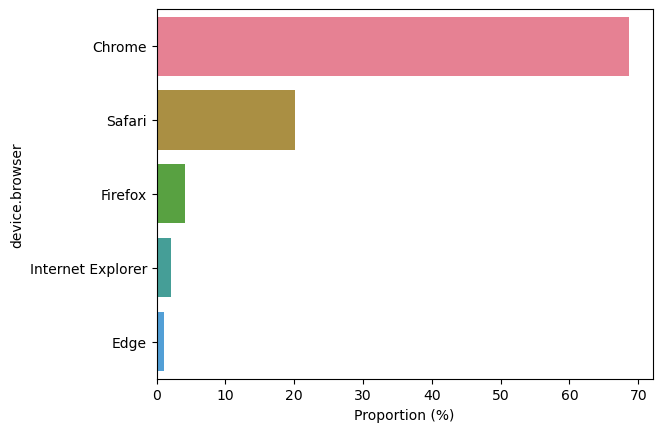

In [30]:
# Count the number of each browser
browser_val_counts = train_df["device.browser"].value_counts(dropna=False)
# Calculate the proportion of each browser
browser_val_proportions = browser_val_counts / browser_val_counts.sum() * 100
# Get small proportion browsers
top_5_common_browser = browser_val_proportions.head(5)

# Viz.
ax = sns.barplot(x=top_5_common_browser.values, 
                 y=top_5_common_browser.index,
                 hue=top_5_common_browser.index,
                 palette=sns.color_palette("husl")[:5]);
ax.set_xlabel("Proportion (%)")

> 💭<u>*Thông tin quan sát được:*</u>
>   * `Chrome` là web-browser được người dùng sử dụng nhiều nhất, chiếm khoảng *70%* tổng số lượt truy cập. Xếp thứ hai là `Safari` với khoảng *20%* tổng số lượt truy cập. Tức là số lượng truy cập từ `Chrome` gấp hơn 3 lần so với số lượng truy cập từ `Safari`.
>
>   * Có thể thấy rằng `Chrome` và `Safari` là 2 browser được sử dụng phổ biến nhất, chỉ 2 browser này đã chiếm khoảng *90%* giá trị trong cột này.
>
>   * Các browser khác như `Firefox`, `IE`, `Edge` cũng được sử dụng tương đối phổ biến nhưng tỷ trọng của chúng không quá lớn như `Chrome` và `Safari`.

##### `device.isMobile` ✅

✍ Phân loại `device.isMobile`:

In [31]:
train_df["device.isMobile"].value_counts(dropna=False)

device.isMobile
False    664530
True     239123
Name: count, dtype: int64

> 💡 <u>*Quan sát*</u>: Thuộc tính này không bị thiếu dữ liệu và tất cả giá trị đều "dễ hiểu" nên ta không cần chỉnh sửa.

##### ⌘ `geoNetwork.country`

❗ Trong cột này có một vài giá trị rỗng là `(not set)`. Ta cần xem tỉ trọng của giá trị này trên toàn bộ cột dữ liệu để quyết định bước xử lý tiếp theo.

In [32]:
# Get `country` column
country = train_df["geoNetwork.country"]

print(f"Proportion of empty values in the column: {country[country == '(not set)'].size / country.size * 100:.2f}%")

Proportion of empty values in the column: 0.16%


🔨 Vì giá trị này không chiếm tỉ trọng quá lớn nên ta có thể xử lý bằng cách thay thế chúng bằng `mode` của cột này

In [33]:
# Get most common value
most_common_country = country.mode()[0]

# Replace empty values with the most common value
train_df["geoNetwork.country"].replace(
    {"(not set)": most_common_country},
    inplace=True
)

🎨 Xem phân bố của các giá trị trong thuộc tính này

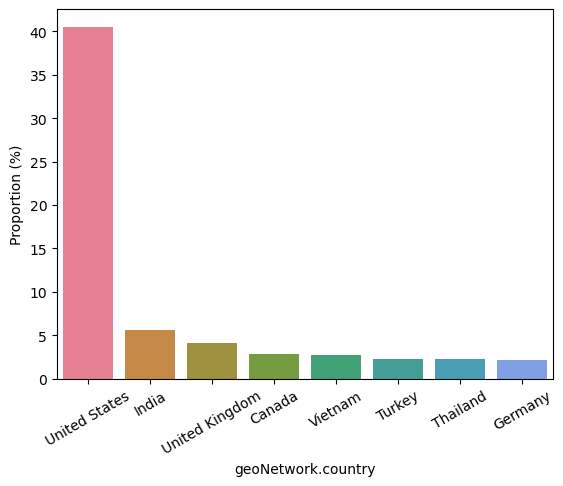

In [34]:
# Get number of each `country` in the column
country_val_counts = train_df["geoNetwork.country"].value_counts(dropna=False)
# Calculate the proportion of each `country`
country_val_proportions = country_val_counts / country_val_counts.sum() * 100
# Get small proportion `country`
top_8_common_country = country_val_proportions.head(8)

# Viz.
ax = sns.barplot(y=top_8_common_country.values, 
                 x=top_8_common_country.index,
                 hue=top_8_common_country.index,
                 palette=sns.color_palette("husl",10)[:8],
                 orient='v');

ax.set_ylabel("Proportion (%)")
ax.xaxis.set_tick_params(rotation=30)
plt.show();

> 💭<u>*Thông tin quan sát được:*</u>
>   * `US` là quốc gia có nhiều lượt truy cập cửa hàng của Google nhất, chiếm khoảng *40%* tổng số lượng truy cập ghi nhận được. 
>
>   * `India` là quốc gia xếp thứ 2 với khoảng *6%* tổng số lượt truy cập, ít hơn khoảng *7* lần so với `US`.
>
>   * Ngoài `US` - `India`, thì các quốc gia còn lại có số lượng truy cập chênh lệch không quá nhiều so với quốc gia xếp ngay bên trên.

##### `device.deviceCategory` ✅

✍ Phân loại `device.deviceCategory`:

In [35]:
train_df["device.deviceCategory"].value_counts(dropna=False)

device.deviceCategory
desktop    664479
mobile     208725
tablet      30449
Name: count, dtype: int64

> 💡 <u>*Quan sát*</u>: Thuộc tính này không bị thiếu dữ liệu và tất cả giá trị đều "dễ hiểu" nên ta không cần chỉnh sửa.

##### ⌘ `geoNetwork.continent`

🎨 Quan sát các giá trị (phân loại) khác nhau và tỉ trọng của chúng

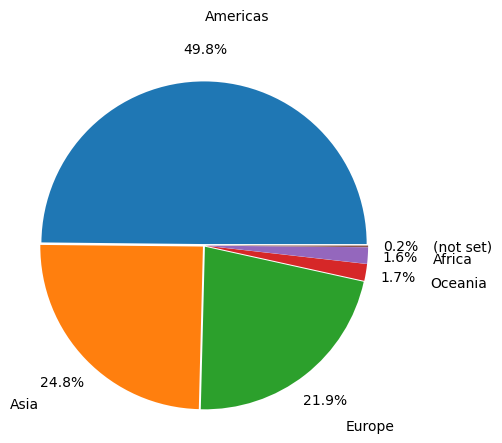

In [36]:
geoNetwork_continent = train_df["geoNetwork.continent"].value_counts(dropna=False)
plt.pie(geoNetwork_continent, radius=1.1, labels=geoNetwork_continent.index, 
        autopct='%1.01f%%', explode=[0.01]*geoNetwork_continent.size,
        pctdistance=1.2, labeldistance=1.4);

> 📝 <u>*Nhận xét:*</u> 
> * Giá trị `Americas` chiếm khoảng *50%* tổng số giá trị (và đồng thời là yếu vị) của thuộc tính này.
> * Ngoài ra, thuộc tính này có khoảng *0.2%* giá trị trống `(not set)`. Do số lượng giá trị bị thiếu là không đáng kể nên ta sẽ thay chúng bằng giá trị `mode` của cột này.

🔨 Thay các giá trị `(not set)` bằng mode của thuộc tính này 

In [37]:
# Find mode of 'geoNetwork.continent'
geo_continent_mode = train_df['geoNetwork.continent'].mode()[0]

# Replace '(not set)' with mode
train_df['geoNetwork.continent'].replace(
    to_replace='(not set)',
    value=geo_continent_mode,
    inplace=True
)

# Check the result
train_df['geoNetwork.continent'].value_counts(dropna=False)

geoNetwork.continent
Americas    451845
Asia        223698
Europe      198311
Oceania      15054
Africa       14745
Name: count, dtype: int64

##### ⌘ `geoNetwork.subContinent`

🔨 Thay giá trị bị trống `(not set)` bằng giá trị `mode` của cột đang xem xét

In [38]:
train_df["geoNetwork.subContinent"].replace(
    {"(not set)": train_df["geoNetwork.subContinent"].mode()[0]},
    inplace=True
)

🎨 Ta quan sát phân bố của một vài giá trị trong cột

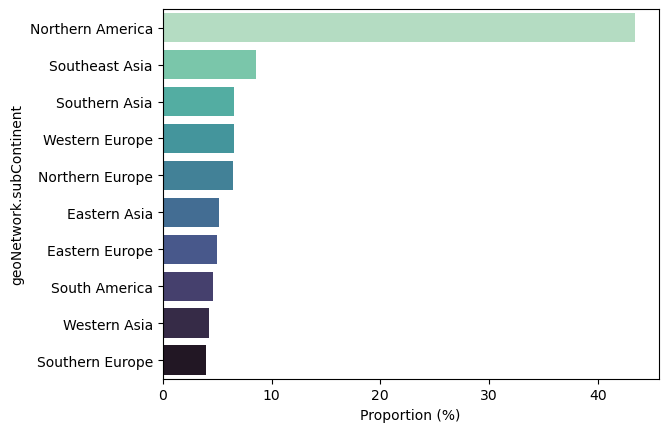

In [39]:
# Get number of each `geoNetwork.subContinent` in the column
sub_continent = train_df["geoNetwork.subContinent"].value_counts(dropna=False)
# Calculate the proportion of each `geoNetwork.subContinent`
sub_continent_proportions = sub_continent / sub_continent.sum() * 100
# Get small proportion `geoNetwork.subContinent`
sub_continent_proportions = sub_continent_proportions.head(10)

# Viz.
ax = sns.barplot(y=sub_continent_proportions.index,
                 x=sub_continent_proportions.values,
                 hue=sub_continent_proportions.index,
                 palette="mako_r",
                 orient='h')
ax.set_xlabel("Proportion (%)");

> 💭<u>*Thông tin quan sát được:*</u>
>   * `Northern America` là tiểu lục địa có nhiều lượt truy cập nhất đến website của Google. Con số này có thể đến phần nhiều từ quốc gia `US` đã đề cập bên trên.

##### 🤔 `geoNetwork.city`

🎨 Ta quan sát phân bố của các giá trị trong cột này

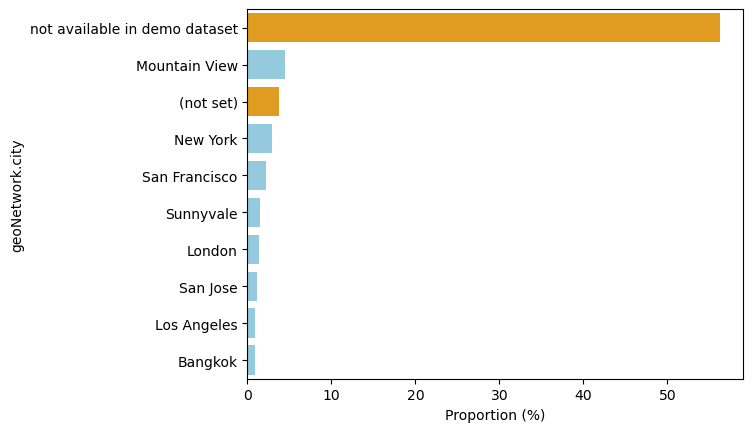

In [40]:
# Calculate proportion of each city
city_proportions = train_df["geoNetwork.city"].value_counts(dropna=False) \
                    / train_df["geoNetwork.city"].size * 100
city_proportions = city_proportions.head(10)

# Color palette to highlight meaningless values
colors = ['orange' if ("not" in x) else 'skyblue' 
          for x in city_proportions.index]
# Visualize
ax = sns.barplot(x=city_proportions.values, 
                 y=city_proportions.index, 
                 hue=city_proportions.index,
                 orient='h',
                 palette=colors)
ax.set_xlabel("Proportion (%)");

> 📝 <u>*Nhận xét:*</u> 
> * Hai giá trị không có nhiều ý nghĩa là `not available in demo dataset` và `(not set)` chiếm khoảng *60%* giá trị của thuộc tính này. Đây là con số có độ lớn trung bình: không quá nhiều nhưng cũng không quá ít.
>
> * Khi này ta có 2 hướng xử lý:
>   1. Ta loại bỏ thuộc tính này ra khỏi tập dữ liệu.
>   2. Gom 2 giá trị bên trên thành 1 nhóm và tiếp tục phân tích khoảng *40%* giá trị có ý nghĩa còn lại.

In [41]:
# TODO:

##### 🤔 `geoNetwork.metro`

🎨 Quan sát các giá trị (phân loại) khác nhau và tỉ trọng của chúng 

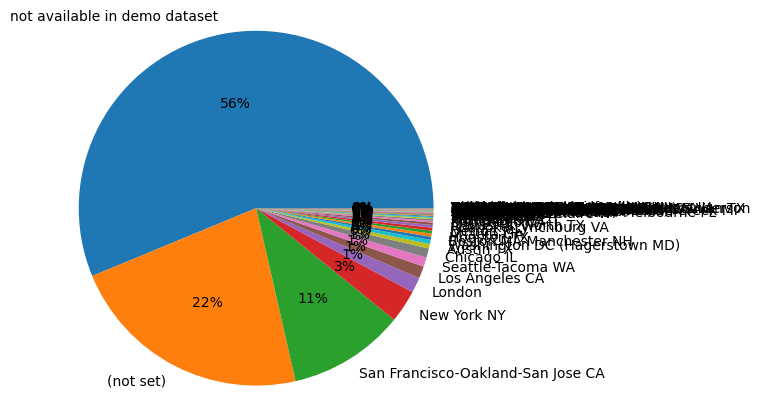

In [42]:
train_df["geoNetwork.metro"].value_counts(dropna=False)\
    .plot.pie(radius=1.2, autopct='%1.0f%%',
              ylabel='');

> 📝 <u>*Nhận xét:*</u>
> * Hai giá trị xuất hiện nhiều nhất là `not available in demo dataset` và `(not set)`. Trên lý thuyết thì cả hai giá trị này đều không đóng góp quá nhiều vào việc giúp ta hiểu hơn về dữ liệu.
>
> * Hơn thế nữa, tổng tỉ trọng của 2 giá trị trên chiếm khoảng *78%* giá trị trong thuộc tính ta đang xem xét, đây là con số khá lớn. 
>
> * Với việc có khoảng 80% giá trị của một cột không có quá nhiều ý nghĩa thì ta có thể <u><i>**cân nhắc**</i></u> việc bỏ cột này khỏi tập dữ liệu.

In [43]:
# TODO:

##### 🤔 `geoNetwork.region`

🎨 Ta quan sát phân bố của các giá trị trong cột này

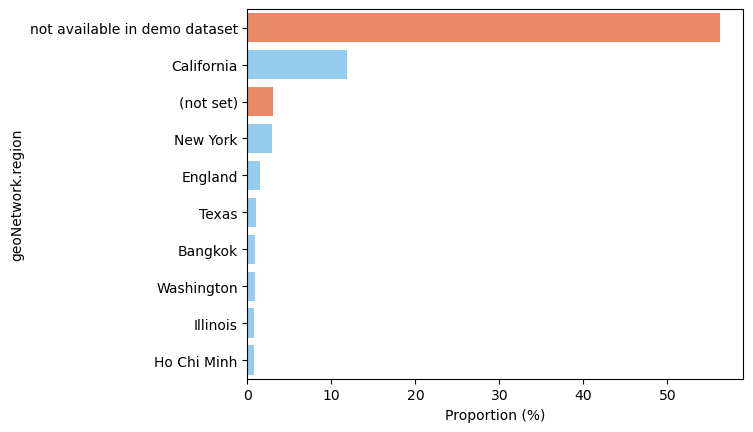

In [44]:
# Calculate proportion of each region
region_proportions = train_df["geoNetwork.region"].value_counts(dropna=False) \
                    / train_df["geoNetwork.region"].size * 100
region_proportions = region_proportions.head(10)

# Color palette to highlight meaningless values
colors = ['coral' if ("not" in x) else 'lightskyblue' 
          for x in region_proportions.index]
# Visualize
ax = sns.barplot(x=region_proportions.values, 
                 y=region_proportions.index, 
                 hue=region_proportions.index,
                 orient='h',
                 palette=colors)
ax.set_xlabel("Proportion (%)");

> 📝 <u>*Nhận xét:*</u> 
> * Cột này có phân bố khá tương đồng với thuộc tính `geoNetwork.city` mà ta đã phân tích bên trên: Hai giá trị không có nhiều ý nghĩa là `not available in demo dataset` và `(not set)` chiếm khoảng *60%* giá trị của thuộc tính này. 
>
> * Do đó, ta sẽ xử lý cột này tương tự như cách đã thực hiện đối với thuộc tính `geoNetwork.city`.

In [45]:
# TODO:

##### ⌘ `geoNetwork.networkDomain`

>   Theo [thông tin tìm kiếm được](https://support.google.com/analytics/answer/3437719?hl=en-GBanswer=1686200#:~:text=geoNetwork.networkDomain) thì `geoNetwork.networkDomain` là tên miền của `ISP` (nhà cung cấp dịch vụ mạng) cho người dùng, xuất phát từ tên miền được đăng ký theo địa chỉ IP của `ISP`. Thuộc tính này không chứa nhiều thông tin hữu ích cho việc phân tích dữ liệu nên nó không còn được hỗ trợ bởi các phiên bản `Google Analytics` sau này. 
>
> **⇨** Từ thông tin thu thập được, ta quyết định loại bỏ cột `geoNetwork.networkDomain` ra khỏi tập dữ liệu.

🔨 Loại bỏ thuộc tính này khỏi tập dữ liệu

In [46]:
# Drop column from the dataframe
if "geoNetwork.networkDomain" in train_df.columns:
    train_df.drop("geoNetwork.networkDomain", axis=1, inplace=True)

##### 🤔 `trafficSource.campaign`

✍ Phân loại `trafficSource.campaign`:

In [47]:
traffic_campaign = train_df["trafficSource.campaign"].value_counts(dropna=False)
traffic_campaign

trafficSource.campaign
(not set)                                          865347
Data Share Promo                                    16403
AW - Dynamic Search Ads Whole Site                  14244
AW - Accessories                                     7070
test-liyuhz                                           392
AW - Electronics                                       96
Retail (DO NOT EDIT owners nophakun and tianyu)        50
AW - Apparel                                           46
All Products                                            4
Data Share                                              1
Name: count, dtype: int64

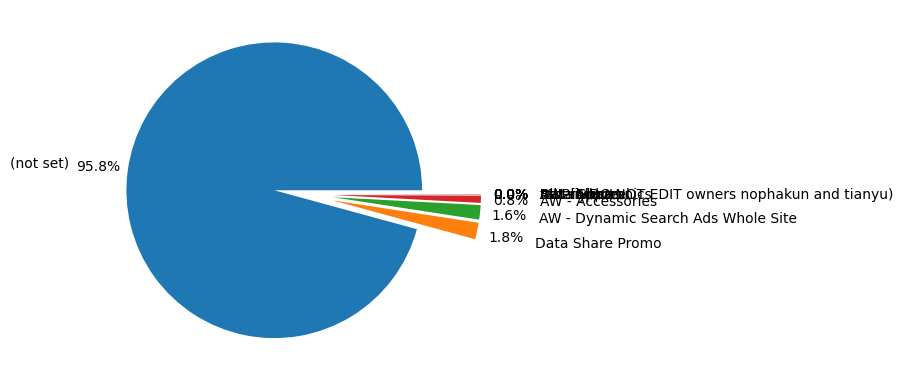

In [48]:
traffic_campaign.plot.pie(
    radius=1., autopct='%1.1f%%',
    pctdistance=1.2, labeldistance=1.4,
    ylabel='',
    explode=[0.2]*len(traffic_campaign)
);

> 📝 <u>*Nhận xét:*</u>
> * Hơn *95%* giá trị trong cột này là `(not set)`, đây là giá trị không có quá nhiều ý nghĩa khi phân tích dữ liệu.
> 
> * Đồng thời, chỉ có 3 chiến dịch quảng cáo: `Data Share Promo`, `AW - Dynamic Search Ads Whole Site` và `AW - Accessories` là có ý nghĩa khi phân tích, các chiến dịch còn lại có số lượng không đáng kể nên ta cũng không cần quan tâm.
>
> * Khi này, ta có 2 hướng xử lý:
>   1. Loại bỏ cột này khỏi tập dữ liệu.
>   2. Gom `(not set)` và một vài giá trị không quan trọng thành 1 nhóm.

In [49]:
# TODO:

##### `totals.hits` ✅

Ta quan sát kiểu giá trị của cột này

In [50]:
train_df['totals.hits'].dtype

dtype('int64')

> Vì kiểu dữ liệu của cột này đã chính xác nên ta không cần xử lý thêm

Ta có thể xem phân bố của cột này

In [51]:
train_df['totals.hits'].describe()

count    903653.000000
mean          4.596538
std           9.641437
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         500.000000
Name: totals.hits, dtype: float64

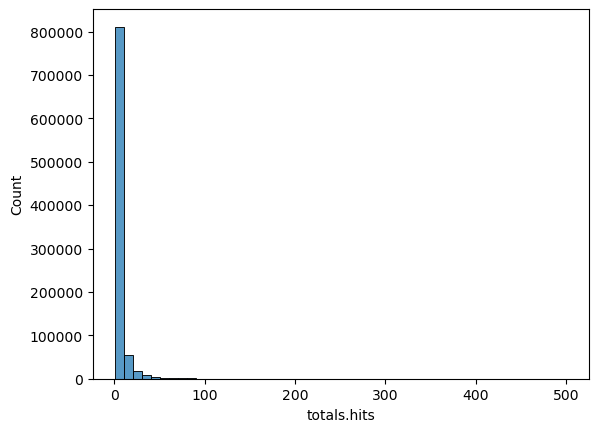

In [52]:
sns.histplot(x=train_df['totals.hits'], bins=50);

##### ⌘ `trafficSource.medium`

✍ Phân loại `trafficSource.medium`:

In [53]:
train_df["trafficSource.medium"].value_counts(dropna=False)

trafficSource.medium
organic      381561
referral     330955
(none)       143026
cpc           25326
affiliate     16403
cpm            6262
(not set)       120
Name: count, dtype: int64

> 💡 <u>Quan sát</u>:
> * Ban đầu ta sẽ nghĩ `(none)` và `(not set)` là giống nhau, nhưng theo bài viết [Direct/None Traffic in Google Analytics 4](https://www.optizent.com/blog/direct-none-traffic-in-google-analytics-4-understanding-the-different-types/): 
>   * "None/Direct web traffic" là thuật ngữ chỉ lượng truy cập của người dùng vào một trang web mà không qua bất kỳ website trung gian (referral source) nào. "Direct traffic" gồm 2 hình thức phổ biến nhất là: nhập URL vào thanh tìm kiếm và dùng bookmarks, và một vài hình thức khác.
>   * Theo một [bài viết khác](https://social.colostate.edu/best-practices/understanding-traffic-source-and-medium-in-google-analytics/#:~:text=If%20Google%20Analytics%20is%20unable%20to%20bucket%20your%20traffic%20into%20any%20of%20the%20above%2Dmentioned%20media%2C%20it%20will%20be%20categorized%20as%20Direct%20traffic.%20SEO%20research%20over%20the%20years%20has%20indicated%20that%20up%20to%2060%25%20of%20the%20traffic%20reported%20as%20Direct%20could%20actually%20be%20organic%20traffic.), có tới 60% lưu lượng truy cập được phân loại "Direct" thì thực sự là "organic". Nhưng trong bài tập này ta chỉ (đơn giản) xem chúng là 2 nhóm khác nhau. 
>
> * Như vậy, ta sẽ đổi giá trị `(none)` trong cột này sang một cái tên có ý nghĩa hơn là `direct` và đổi giá trị `(not set)` thành `others`.

🔨 Chuyển giá trị `(none)` $\to$ `direct` và `(not set)` $\to$ `others`

In [54]:
# Change some trafficSource.medium column's names
train_df["trafficSource.medium"].replace({
    "(none)": "direct",
    "(not set)": "others"
}, inplace=True)

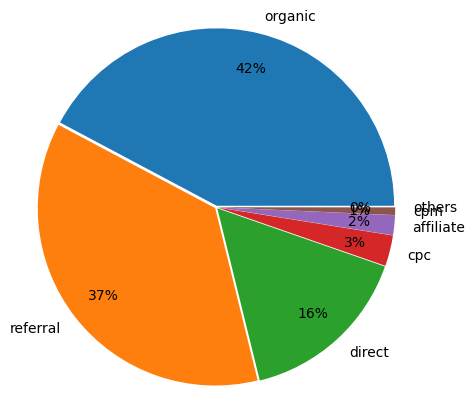

In [55]:
train_df["trafficSource.medium"].value_counts(dropna=False)\
    .plot.pie(radius=1.2, autopct='%1.0f%%', ylabel='', pctdistance=0.8,
              explode=[0.01]*train_df["trafficSource.medium"].nunique());

##### ⌘ `trafficSource.source`

🔨 Vì cột này có rất nhiều dữ liệu tương đồng nên ta sẽ gom cụm chúng thông qua kết quả của mô hình `KMeans`.

In [56]:
def _clustering_traffic_source(x):
    if   'direct'           in x: return 'direct'
    elif 'googleplex'       in x: return 'googleplex'
    elif 'partners'         in x: return 'partners'
    elif 'siliconvalley'    in x: return 'siliconvalley'
    elif 'dfa'              in x: return 'DoubleClick for Advertisers'
    elif 'bing'             in x: return 'bing'
    elif 'yahoo'            in x: return 'yahoo'
    elif 'search'           in x: return 'other search engines'
    elif 'ask'              in x: return 'other search engines'
    elif 'pinterest'        in x: return 'pinterest'
    elif 'youtube'          in x: return 'youtube'
    elif 'images.google'    in x: return 'google images'
    elif 'baidu'            in x: return 'baidu'
    elif 'github'           in x: return 'github'
    elif 'facebook'         in x: return 'facebook'
    elif 'twitter'          in x: return 'twitter'
    elif 't.co'             in x: return 'twitter'
    elif 'telegram'         in x: return 'telegram'
    elif 'whatsapp'         in x: return 'whatsapp'
    elif 'reddit'           in x: return 'reddit'
    elif 'qiita'            in x: return 'qiita'
    elif 'quora'            in x: return 'quora'
    elif 'linkedin'         in x: return 'linkedin'
    elif 'amazon'           in x: return 'amazon'
    elif 'messenger'        in x: return 'messenger'
    elif 'yandex'           in x: return 'yandex'
    elif 'direct'           in x: return 'direct'
    elif 'adwords'          in x: return 'adwords'
    elif 'adz'              in x: return 'adwords'
    elif 'ads'              in x: return 'adwords'
    elif 'businessinsider'  in x: return 'businessinsider'
    elif 'google'           in x: return 'google'
    else: return 'others'

In [57]:
# Get trafficSource.source column
traffic_source = train_df['trafficSource.source'].copy()

# Standardize trafficSource.source column
traffic_source = traffic_source.apply(lambda x: x.lower())
traffic_source = traffic_source.apply(lambda x: re.sub(r":[\d]*$", '', x))
traffic_source = traffic_source.apply(lambda x: re.sub(r"\.com[\w\.]*$", '', x))
traffic_source = traffic_source.apply(_clustering_traffic_source)

# Reassign trafficSource.source column
train_df['trafficSource.source'] = traffic_source

🎨 Ta quan sát phân bố của các giá trị trong cột sau khi biến đổi 

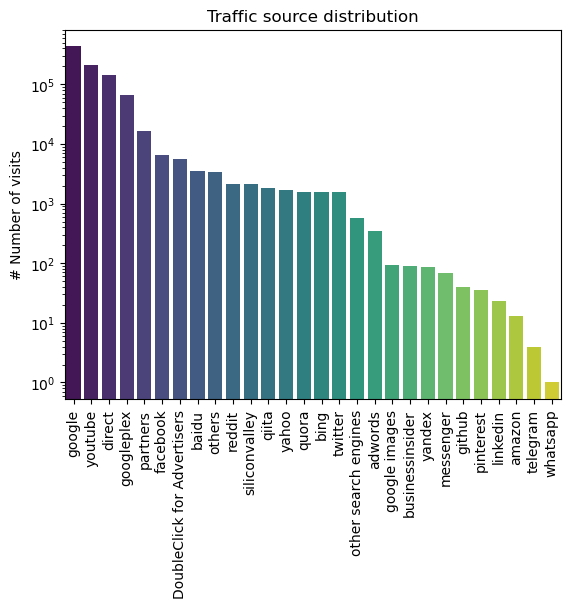

In [58]:
# Get number of each `trafficSource.source` in the column
traffic_source_val_counts = train_df["trafficSource.source"].value_counts(dropna=False)
# traffic_source_val_counts = traffic_source.value_counts(dropna=False)

# Viz.
ax = sns.barplot(x=traffic_source_val_counts.index,
                 y=traffic_source_val_counts.values,
                 hue=traffic_source_val_counts.index,
                 palette="viridis",
                 orient='x')

# Set x-axis, y-axis and title
ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("");
ax.set_ylabel("# Number of visits");
ax.set_title("Traffic source distribution");

plt.yscale('log')
plt.show();

#### 💾 Ta lưu lại dữ liệu này để backup

In [59]:
train_df.to_csv('../data/processed/train_preprocessed.csv', index=False, na_rep='None')

In [60]:
train_df = pd.read_csv('../data/processed/train_preprocessed.csv')

# ---------- BREAK ----------

In [61]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   channelGrouping          903653 non-null  object
 1   visitNumber              903653 non-null  int64 
 2   device.browser           903653 non-null  object
 3   device.operatingSystem   903653 non-null  object
 4   device.isMobile          903653 non-null  bool  
 5   device.deviceCategory    903653 non-null  object
 6   geoNetwork.continent     903653 non-null  object
 7   geoNetwork.subContinent  903653 non-null  object
 8   geoNetwork.country       903653 non-null  object
 9   geoNetwork.region        903653 non-null  object
 10  geoNetwork.metro         903653 non-null  object
 11  geoNetwork.city          903653 non-null  object
 12  totals.hits              903653 non-null  int64 
 13  totals.pageviews         903653 non-null  int64 
 14  trafficSource.campai

In [62]:
train_df.shape

(903653, 22)

In [63]:
# train_df['geoNetwork.networkDomain'].value_counts(dropna=False).plot.pie(
#     radius=1.2, autopct='%1.0f%%', ylabel='', pctdistance=0.8,
#     )

In [64]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.cluster import KMeans
# import numpy as np

# # Your list of text values
# text_values = [
#     # ... (paste your list here)
# ]
# text_values = s.value_counts().index
# # Convert text to numerical data using TF-IDF
# vectorizer = TfidfVectorizer(stop_words='english')
# X = vectorizer.fit_transform(text_values)

# # Choose the number of clusters (you may need to adjust this based on your data)
# num_clusters = 15

# # Apply K-Means clustering
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# kmeans.fit(X)

# # Get cluster labels
# cluster_labels = kmeans.labels_

# # Print the clusters
# for i in range(num_clusters):
#     print(f"Cluster {i + 1}:")
#     cluster_texts = np.array(text_values)[cluster_labels == i]
#     for text in cluster_texts:
#         print(f"  - {text}")
#     print("\n")

In [65]:
# def _clustering_keyword(x):
#     if 'tube'       in x: return "youtube"
#     if 'tub'        in x: return "youtube"
#     if 'you'        in x: return "youtube"
#     if 'yot'        in x: return "youtube"
#     if 'yu'         in x: return "youtube"
#     if 'yt'         in x: return "youtube"
#     if 'ypu'        in x: return "youtube"
#     if 'ube'        in x: return "youtube"
#     if 'tbe'        in x: return "youtube"
#     if 'tobe'       in x: return "youtube"
#     if 'yoo'        in x: return "youtube"
#     if 'υουτυβε'    in x: return "youtube"
#     if 'yoiu'       in x: return "youtube"
#     if 'tuibe'      in x: return "youtube"
#     if 'tbue'       in x: return "youtube"
    
#     if 'buy'    in x and 'google'   in x: return "buy + google"
#     if 'shirt'  in x and 'google'   in x: return "google + (t-)shirt"
#     if 'shirt'  in x and 'goog'     in x: return "google + (t-)shirt"
#     if 'lava'   in x and 'lamp'     in x: return "lava + lamp"
    
    
#     if ("goog" in x or "goof" in x or "geogle" in x or "geogle" in x or "oolge" in x) \
#         and ('mer' in x or 'mar' in x or 'chandise' in x or 'sto' in x or 'ore' in x \
#                 or 'stroe' in x or 'shop' in x):
#         return "google + merchandise/store/shop"
    
#     if 'bottle' in x or 'boottle' in x or 'botl' in x: 
#         return "(water) bottle"
#     if 'bag' in x and 'google' not in x: 
#         return "bag"
    
#     if 'google' in x or 'goog' in x or 'oogle' in x: 
#         return "google (brand)"
    
#     if ("android" in x) and ('mer' in x or 'mar' in x or 'chandise' in x \
#         or 'sto' in x or 'ore' in x  or 'stroe' in x or 'shop' in x):
#         return "android + merchandise/store/shop"
#     if "android" in x or "andriod" in x: 
#         return "android (brand)"
    
#     if ('chandise' in x or 'mer' in x or 'mar' in x or 'shop' in x or 'store' in x):
#         return "other merchandise/store/shop"
    
#     if "sunglasses" in x: return "sunglasses"
#     if "shirt" in x or "shart" in x or "shert" in x or "shi" in x or "shrit" in x \
#         or "shrt" in x or "shet" in x or "sirt" in x: 
#         return "(t-)shirt"
    
#     if "pen"        in x: return "pen"
#     if "nest"       in x: return "pen"
#     if "mug"        in x: return "mug"
#     if "stickers"   in x: return "stickers"
#     if "bluetooth"  in x: return "bluetooth"
#     if "tumblers"   in x: return "tumblers"
#     if "apparel"    in x: return "apparel"
#     if "backpack"   in x: return "backpack"
#     if "hoodie"     in x: return "hoodie"
    
#     if "journal" in x or "notebook" in x: 
#         return "notebooks + journals"
    
#     return "others"

In [66]:
# s = train_df['trafficSource.keyword'].copy()
# s = s.apply(lambda x: str(x).replace('+', ''))
# s = s.apply(lambda x: str(x).lower())
# s = s.apply(lambda x: re.sub(r"goo[oh]gle?", 'google', x))
# s = s.apply(lambda x: re.sub(r"gog[g]?le", 'google', x))
# s = s.apply(lambda x: re.sub(r"goole", 'google', x))
# s = s.apply(lambda x: re.sub(r"goo[l]?gel", 'google', x))
# s = s.apply(lambda x: re.sub(r"gog[oa]le", 'google', x))
# s = s.apply(lambda x: re.sub(r"\.?g[ou]gel\.?", 'google', x))
# s = s.apply(lambda x: re.sub(r"gtoogle", 'google', x))
# s = s.apply(lambda x: re.sub(r"g(ò|po|\.\.|oi|aa|ol|ood|ou|ool|opp)g(le|al)", 'google', x))
# s = s.apply(lambda x: re.sub(r"\woo[gh]le", 'google', x))
# s = s.apply(_my_func)
# s.value_counts(dropna=False).shape